# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 - What is the probability that a person is drunk after two positive breathalyzer tests?
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).



In [0]:
#You should only truly need these two values in order to apply Bayes Theorem.
# In this example, imagine that individuals are taking a breathalyzer test 
# with an 8% false positive rate, a 100% true positive rate, 
#and that our prior belief about drunk driving in the population is 1/1000.


#What is the probability that a person is drunk after one positive breathalyzer test?
#What is the probability that a person is drunk after two positive breathalyzer tests?
#How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?


#defining the prior belief
p_user = 1/1000
#defining the probability in general pop to be a non_user
p_non_user = 1 - p_user
#defining the probability of a true pos
p_test_pos_given_drunk = 1
#defining the false pos
p_test_pos_given_not_drunk = .08


def prob_drunk_given_positive(prob_drunk_prior_belief, false_positive_rate,
                              true_pos_rate, numTest ):
  posterior = prob_drunk_prior_belief

  #making the loop to loop through the num of tests
  for test in range(numTest):
    #defining the probabilities probability of being drunk
    p_drunk = posterior
    #prob of being a not drunk 
    p_notDrunk = 1 - p_user
    #prob of testing pos if drunk (true pos rate)
    p_test_pos_given_drunk = true_pos_rate
    #prob of testing drunk but not drunk
    p_test_pos_given_not_drunk = false_positive_rate

    #creating the numerator and the denominator
    numerator = p_test_pos_given_drunk * p_drunk
    denominator = (p_test_pos_given_drunk * p_drunk) + (p_test_pos_given_not_drunk * p_notDrunk)
    
    posterior = numerator/denominator


  return posterior

In [4]:
#after one test the probability that they are actually drunk when testing pos
#is
print("after one test the probability they they are drunk is: ",prob_drunk_given_positive(1/1000, .08, 1, 1) )

after one test the probability they they are drunk is:  0.012357884330202669


In [5]:
#after two tests
print('the probability after two test is: ', prob_drunk_given_positive(1/1000, .08, 1, 2))

the probability after two test is:  0.13392032576279944


In [17]:
#you never get to 95 percent probability only will reach 92
prob_drunk_given_positive(1/1000, .08, 1,30000000)

0.92008

In [0]:
#finding the number of tests that it will need to do to get at least 95 % 
#probability

def findNumTests(prior, trp, fp):
  newPrior = prior
  count = 0
  #running a loop to run the test til get to 95% prob
  while newPrior <= .95:
    count = count + 1
    newPrior = prob_drunk_given_positive(newPrior, fp, trp, 1)
  
  return count

In [0]:
# ran this forever and never reach 95% probability
num = findNumTests(1/1000, 1, .08 )
print("the number of tests needed to reach 95% prob is: ", num)

In [0]:
#This is my write up of what bayseian statistics is compared to frequestist statistics.

# A bayesian statatician will use prior knowledge to affect his reasoning.  Where a frequentis won't use prior knowledge but will just use the 
# frequency (likelihood) of the something happening.  This could be as in the example of a frequentist would say the likelihood of getting any number
# on a die is one in six, because there are 6 different sides to the die.  A bayesian statatician will look at the past times the die has rolled to see the 
# ratio of the rolls, and then use this prior knowledge to help calculate the probability of what numbers may come up next on the die.

# Another example would be I have lost my phone in my home.  If I press the locator button on the base the phone will begin to ring.  A bayesian
# way of thinking would use the sound of the phone to locate it to an area of the home.  He would then combine this knowledge with his knowledge
# of where he has on prior occasions left the phone in the home.  Using these two pieces of info, he would go and locate the phone.
# The frequentist would just use the sound of the phone to locate where it is in his home, and not combine this with prior knowledge of where he leaves his phone.

In [0]:
#using the scipy stats module to look at the bayesian confidence intervals
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np


In [22]:
#will be doing the random coinflips
flips = np.random.binomial(1, .5, 100)
flips.mean()

0.48

In [28]:
confidenceInt = stats.bayes_mvs(flips,  .9)
confidenceMean = confidenceInt[0]
confidenceMean

Mean(statistic=0.48, minmax=(0.3966289819625553, 0.5633710180374446))

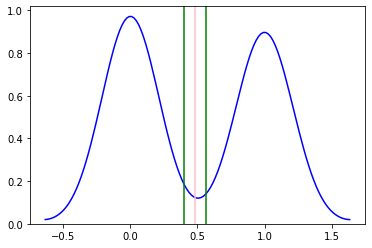

In [31]:
#building the graph this is with puttin the confidence interval at 90%
sns.kdeplot(flips, color= "blue")
plt.axvline(x= confidenceMean[1][0],  color="green")
plt.axvline(x=confidenceMean[1][1], color = "green")
plt.axvline(x=flips.mean(), color="pink");

## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!